In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf


In [ ]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [ ]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [ ]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = "/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')
test_generator = data_generator_3.flow_from_directory(
    directory = "/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 148 images belonging to 2 classes.
Data Augmentation 1 was used to generate train data set

Found 40 images belonging to 2 classes.


In [ ]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


In [ ]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [ ]:
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()


Dataset Characteristics of Train Data Set:
Number of images: 148
Number of normal images: 74
Number of pneumonia images: 74

Dataset Characteristics of Test Data Set:
Number of images: 40
Number of normal images: 20
Number of pneumonia images: 20



In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0}

Train image data from Data Augmentation 1


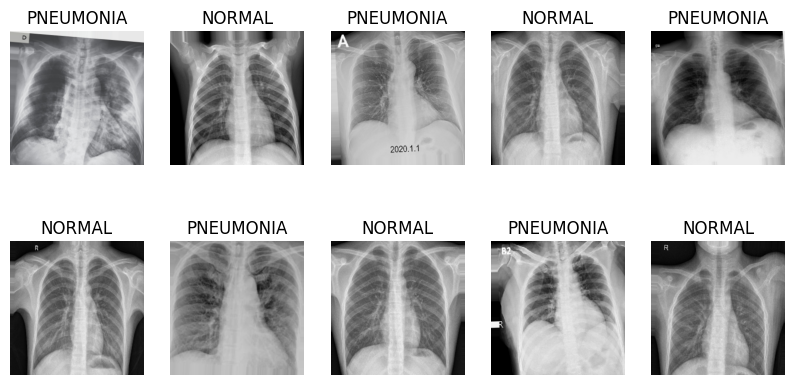

In [ ]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [ ]:
train_data = train_generator1
EPOCHS = 2
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False
          # Create a new model and add the VGG16 base model
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

Model Summary (VGG16):
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                               